# Substructure Matching

Trying to figure out if a substructure is present in one or more molecules is one of the most common filtering steps in cheminformatics.

Here, we explore some code snippets that will do substructure matching

[Detect if a substructure is present in a dataframe of smiles](#substructure-matching-in-a-dataframe)

[Highlight a substructure in molecule grid](#highlight-a-given-substructure)

[Highlight differences amongst molecules](#highlight-differences-amongst-molecules)

[Finding the maximum common substructure (MCS)](#find-maximum-common-substructure-mcs)

## Substructure Matching in a Dataframe:

In [83]:
# Import the necessary libraries

import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdFMCS
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors

import rdkit
print(f"I am RDKit version: {rdkit.__version__}")
import sys
print(f"I am python version {sys.version}")

I am RDKit version: 2023.09.5
I am python version 3.10.0 (default, Feb 27 2024, 12:29:18) [Clang 15.0.0 (clang-1500.1.0.2.5)]


In [84]:
#import a sample dataset containing SMILES:

pi3k = pd.read_csv("data/FINE_TUNING_pi3k-mtor_objectives.csv")
pi3k.head(3)

,SMILES,pKi IC50 Pi3K,pKi IC50 mTor,Water Solubility,Caco2 permeability,CYP1A2 inhibitor,CYP3A4 inhibitor,Total Clearance
0,Cc1ncnc(-c2ccc(cc2)C(=O)N2CCN3CCCCC3C2)c1C#Cc1...,7.091515,7.769551,-3.540,1.377,0.0,1.0,NaN
1,Cc1ncnc(-c2ccc(cc2)C(C)(C)C#N)c1C#Cc1ccc(N)nc1,7.619789,7.619789,-3.864,1.302,1.0,1.0,0.798
2,Cc1ncnc(-c2ccc(cc2)S(C)(=O)=O)c1C#Cc1ccc(N)nc1,7.187087,8.096910,-3.535,0.274,1.0,1.0,0.899


In [85]:
# Calculate the mol object:

pi3k['mol'] = pi3k['SMILES'].apply(lambda x: Descriptors.Chem.MolFromSmiles(x))

In [86]:
#Define the pattern we wish to see:
pattern = 'c1ccccc1C(=O)N'
pattern_mol = Chem.MolFromSmarts('c1ccccc1C(=O)N')

#create an empty list to store matched molecules from the dataframe:
matches_mol = [] 

# Define a function to detect the pattern:
def sub_match(mol):

    if mol.HasSubstructMatch(pattern_mol) == True:
        
        matches_mol.append(Chem.MolToSmiles(mol))
        return "True"
    
    else:
        return "False"

In [87]:
pi3k['sub_present?'] = pi3k['mol'].apply(lambda x: sub_match(x))

In [88]:
pi3k.head(3)

,SMILES,pKi IC50 Pi3K,pKi IC50 mTor,Water Solubility,Caco2 permeability,CYP1A2 inhibitor,CYP3A4 inhibitor,Total Clearance,mol,sub_present?
0,Cc1ncnc(-c2ccc(cc2)C(=O)N2CCN3CCCCC3C2)c1C#Cc1...,7.091515,7.769551,-3.540,1.377,0.0,1.0,NaN,<rdkit.Chem.rdchem.Mol object at 0x16b2c2ce0>,True
1,Cc1ncnc(-c2ccc(cc2)C(C)(C)C#N)c1C#Cc1ccc(N)nc1,7.619789,7.619789,-3.864,1.302,1.0,1.0,0.798,<rdkit.Chem.rdchem.Mol object at 0x16b2c2b20>,False
2,Cc1ncnc(-c2ccc(cc2)S(C)(=O)=O)c1C#Cc1ccc(N)nc1,7.187087,8.096910,-3.535,0.274,1.0,1.0,0.899,<rdkit.Chem.rdchem.Mol object at 0x16b2c2dc0>,False


## Highlight a given substructure:

We can see that the first smiles in the dataframe contains the pattern as it is labelled "True"

Let's visualise them:

In [89]:
# Select only the first 5 molecules:
pi3k_true = pi3k.loc[pi3k['sub_present?']=="True"].head(5)

# First we define the atoms that we wish to highlight

highlight_pattern = [mMol.GetSubstructMatch(Chem.MolFromSmiles(pattern)) for mMol in pi3k_true['mol']]
#print(highlight_pattern)

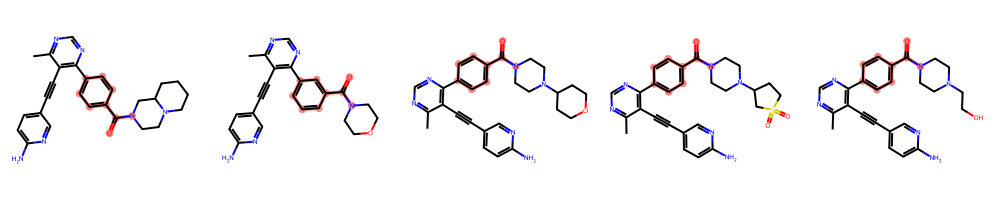

In [90]:
from rdkit.Chem import Draw

Draw.MolsToGridImage(pi3k_true.mol, molsPerRow=5, highlightAtomLists = highlight_pattern, useSVG=False)

Let's visualise the pattern in this first molecule, using a higlighter:

((8, 7, 6, 11, 10, 9, 12, 13, 14),)


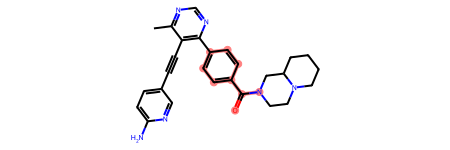

In [91]:
from rdkit.Chem.Draw import rdMolDraw2D

m = Chem.MolFromSmiles(pi3k.SMILES[0])
substructure = Chem.MolFromSmarts('c1ccccc1C(=O)N')

#one can also get the atom indices of the pattern in the parent molecule
print(m.GetSubstructMatches(substructure))

m

## Highlight differences amongst molecules:

In [92]:
from rdkit.Chem import PandasTools
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol

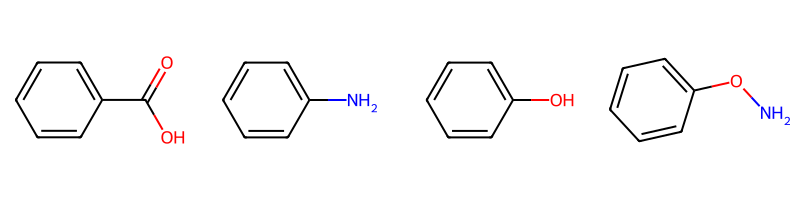

In [93]:
# Consider a sample dataframe:

smi = pd.DataFrame({'smiles': ['c1ccccc1C(=O)O', 'c1ccccc1N', 'c1ccccc1O', 'c1ccccc1ON']})
smi['mol'] = smi.smiles.apply(Chem.MolFromSmiles)

Draw.MolsToGridImage(smi.mol, molsPerRow=4)

[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1


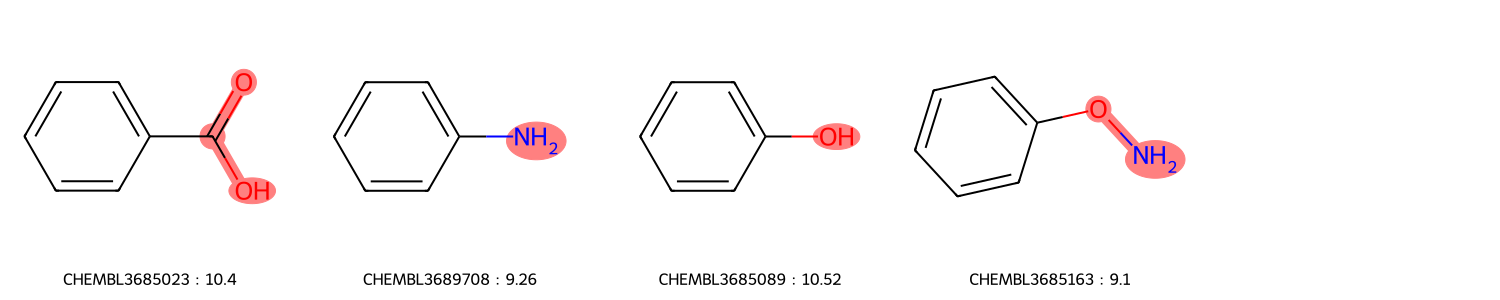

In [94]:
# Find MCS between all the molecules:
mcs = rdFMCS.FindMCS(smi.mol.values)
print(mcs.smartsString)
mol_scaffold_of_interest = Chem.MolFromSmarts(mcs.smartsString)

# Function to determine the atoms that are different amongst all molecules
def get_atoms_to_highlight(mol_scaffold_of_interest, mol_compound_of_interest):
    atom_list = [i for i in range(mol_compound_of_interest.GetNumAtoms())]
    grouped_common_atoms = mol_compound_of_interest.GetSubstructMatches(mol_scaffold_of_interest)
    flattened_grouped_common_atoms = list(sum(grouped_common_atoms, ()))
    atoms_to_highlight = list(set(atom_list) - set(flattened_grouped_common_atoms))
    return atoms_to_highlight

# Call the above function here
hl_atom_list = []
for each_mol in smi['mol']:
    highlight = get_atoms_to_highlight(mol_scaffold_of_interest, each_mol)
    each_mol.__sssAtoms = highlight
    hl_atom_list.append(highlight)

# Draw the molecules with differences highlighted: 
Draw.MolsToGridImage(smi['mol'].values, 
                     legends=custom_legend, 
                     highlightAtomLists = hl_atom_list, 
                     molsPerRow=5,
                     subImgSize=(300,300), 
                     useSVG=False)

## Find Maximum Common Substructure (MCS):

In [95]:
from rdkit import Chem
from rdkit.Chem import rdFMCS

#define a dataframe
smi = pd.DataFrame({'smiles': ['c1ccccc1C(=O)O', 'c1ccccc1N', 'c1ccccc1O', 'c1ccccc1ON']})

#get the mol objectt
smi['mol'] = smi.smiles.apply(Chem.MolFromSmiles)

mc = rdFMCS.FindMCS(smi.mol)

print(f"MC contains {mc.numAtoms} atoms and {mc.numBonds} bonds.")
print("MCS SMARTS string:", mc.smartsString)


MC contains 6 atoms and 6 bonds.
MCS SMARTS string: [#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1


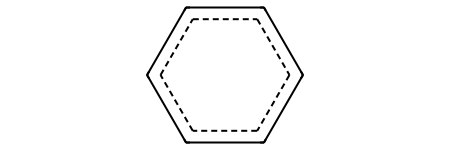

In [96]:
# how the mcs looks like:
Chem.MolFromSmarts("[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1")

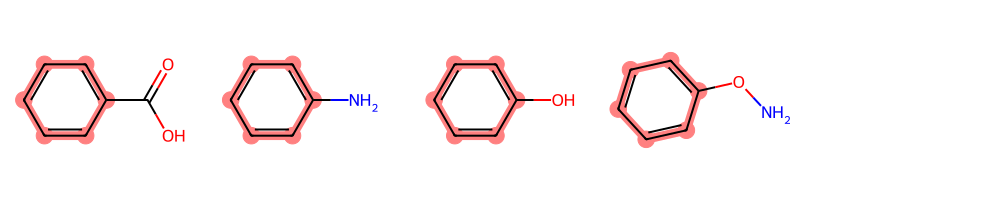

In [97]:
# Lets visualise it:

highlight_pattern = [mMol.GetSubstructMatch(Chem.MolFromSmarts("[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1")) for mMol in smi['mol']]
Draw.MolsToGridImage(smi.mol, molsPerRow=5, highlightAtomLists = highlight_pattern)

## Another succint way towards substructure matching as written by Copilot:

In [98]:
def check_substructure(df, substructure_smiles):
    """
    Checks if SMILES strings in the DataFrame contain the specified substructure.

    Args:
        df (pd.DataFrame): DataFrame containing a 'smiles' column with SMILES strings.
        substructure_smiles (str): SMILES string representing the substructure to search for.

    Returns:
        pd.Series: A boolean Series indicating whether each SMILES contains the substructure.
    """
    substructure_mol = Chem.MolFromSmiles(substructure_smiles)
    if substructure_mol is None:
        raise ValueError("Invalid substructure SMILES.")

    def has_substructure(smiles):
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None and mol.HasSubstructMatch(substructure_mol)

    return df['smiles'].apply(has_substructure)

# Example usage:
if __name__ == "__main__":
    # Load your SMILES data into a pandas DataFrame 'df'
    # Assuming 'df' has a column named 'smiles'
    smiles_df = pd.DataFrame({'smiles': ['CCO', 'C1CCCC1', 'CNC']})

    # Specify the substructure SMILES you want to search for
    my_substructure = 'CCO'  # Example: Ethanol

    # Check if each SMILES contains the specified substructure
    result_series = check_substructure(smiles_df, my_substructure)
    print(result_series)
    
    lldata = smiles_df.merge(pd.DataFrame(result_series), how='left', left_index=True, right_index=True)

0     True
1    False
2    False
Name: smiles, dtype: bool


In [99]:
lldata

,smiles_x,smiles_y
0,CCO,True
1,C1CCCC1,False
2,CNC,False
